In [22]:
import glob
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.patches as mpatches
from pandas import DataFrame
from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


In [46]:
# PART 1: Retrieval
LOAD_WHOLE_DATASET = True

# See data/REAMD.md for longer names/details.
columns = ['x', 'y', 'z', 'label']
label_i = [1, 2, 3, 4, 5, 6, 7]
labels = ['Computer', 'Moving', 'Standing', 'Walking', 'Stairs',
          'Walking + talking', 'Standing + talking']
labels_short = ['Computer', 'Move', 'Stand', 'Walk', 'Stairs',
          'Walk+talk', 'Stand+talk']
# Map numeric label to user friendly names
labels_map = {
    1: 'Computer',
    2: 'Moving',
    3: 'Standing',
    4: 'Walking',
    5: 'Stairs',
    6: 'Walking + talking',
    7: 'Standing + talking'
}

accs = ['x', 'y', 'z']

label_color = {
    'Computer': 'red',
    'Moving': 'green',
    'Standing': 'black',
    'Walking': 'yellow',
    'Stairs': 'cyan',
    'Walking + talking': 'orange',
    'Standing + talking': 'purple' ,
}


ad = DataFrame()
# find all csv files
if LOAD_WHOLE_DATASET:
    files = glob.glob('data/*.csv')
else:
    files = ['data/2.csv']

# concatenate all 15 data files
# usecols is used to skip reading the 'id' column, which has errors
for file in files:
    person_data = pd.read_csv(file, sep=',', header=None, names=columns,
                 usecols=[1,2,3,4])
    # Add a column person, which specifies which dataset a row is from
    person_id = file.split('data/')[1].split('.csv')[0]
    person_data['person'] = int(person_id)

    ad = pd.concat([ad, person_data])


In [47]:
# Drop rows with not a valid label
ad = ad.loc[(ad['label'] >= 1) & (ad['label'] <= 7), :]

In [48]:
# Add new columns, readable label column and color
ad['label_readable'] = ad['label'].map(labels_map)

# add a color to each class (label)
ad['color'] = ad['label_readable'].map(label_color)


In [57]:
# check data
print('\nShape')
print(ad.shape)
# Check head and tail
print('\nHead')
print(ad.head())
print('\nTail')
print(ad.tail())
# Check if any value is NaN, if this was the case those rows would need to be cleaned.
print('\nColumns with NaNs')
print(ad.isna().any())


Shape
(1923177, 7)

Head
      x     y     z  label  person label_readable color
0  1955  2302  1766      1      14       Computer   red
1  1954  2293  1770      1      14       Computer   red
2  1959  2298  1780      1      14       Computer   red
3  1954  2299  1774      1      14       Computer   red
4  1952  2301  1772      1      14       Computer   red

Tail
           x     y     z  label  person      label_readable   color
137995  1700  1845  2034      7       8  Standing + talking  purple
137996  1695  1844  2035      7       8  Standing + talking  purple
137997  1700  1847  2034      7       8  Standing + talking  purple
137998  1708  1849  2031      7       8  Standing + talking  purple
137999  1709  1853  2026      7       8  Standing + talking  purple

Columns with NaNs
x                 False
y                 False
z                 False
label             False
person            False
label_readable    False
color             False
dtype: bool


In [6]:
# Investigate data, show data type, max/min, label count.
for column in columns:
    print()
    print(f"Column: {column}, dtype: {ad[column].dtype}")

    if column == 'label':
        print(f"Label count:\n{ad[column].value_counts()}")
    elif column in accs:
        print(column, 'min, max:', ad[column].min(), ad[column].max())
        print(column, 'mean, std:', ad[column].mean(), ad[column].std())

        print('Sorted head:')
        print(ad[column].sort_values().head(10))
        print('Sorted tail:')
        print(ad[column].sort_values().tail(10))

# From the output above we can see the data is unbalanced, 'moving' has 928 data points,
# while 'standing + walking' has 83748. When using knn, the feature with most
# data points will be favoured.

# We also see that y, z have data points which seem faulty. There are a few of
# abnormally small and big values (e.g. 2 and 4095).

# We can investigate the abnormal y and z values further:
outs_y = ad.loc[(ad['y'] > 3800) | (ad['y'] < 200), :]
outs_z = ad.loc[(ad['z'] > 3800) | (ad['z'] < 200), :]
print('\ny outliers:')
print(outs_y.sort_values(by='y'))
print('z outliers:')
print(outs_z.sort_values(by='z'))
# We see they often correlate, a small y follows a big z, and vice versa,
# but not always. All are for 'Computer' class


Column: x, dtype: int64
x min max: 282 3828
Sorted head:
1631    282
1608    312
51      321
1597    368
1609    403
1586    435
888     483
1619    494
50      516
878     520
Name: x, dtype: int64
Sorted tail:
2267    3529
1959    3566
2265    3577
1971    3603
1935    3618
2266    3625
883     3626
893     3637
894     3674
1972    3828
Name: x, dtype: int64

Column: y, dtype: int64
y min max: 2 4095
Sorted head:
2272    2
2248    2
2249    2
2271    2
2261    2
867     2
868     2
2260    2
878     2
877     2
Name: y, dtype: int64
Sorted tail:
874     4087
2265    4091
872     4093
2266    4094
883     4094
884     4094
893     4094
882     4095
873     4095
894     4095
Name: y, dtype: int64

Column: z, dtype: int64
z min max: 1 4095
Sorted head:
1624    1
1613    2
1929    2
1930    2
1941    2
1614    2
1917    2
1603    2
1602    2
1918    2
Name: z, dtype: int64
Sorted tail:
1923    3868
1911    4091
2261    4092
2272    4093
2270    4094
2260    4094
2259    4094
2271    40

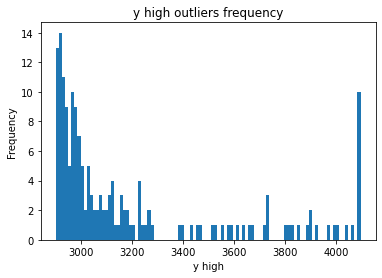

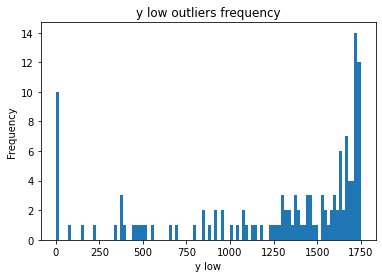

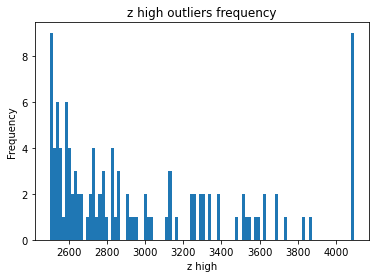

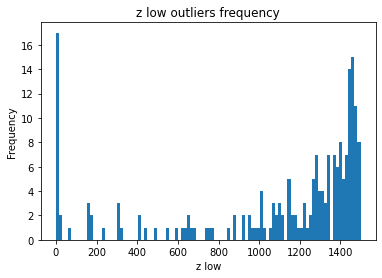

In [7]:
# I will investigate further, and look at the distribution
# of the outliers. 
outs_yh = ad.loc[(ad['y'] > 2900), 'y']
outs_yl = ad.loc[(ad['y'] < 1750), 'y']
outs_zh = ad.loc[(ad['z'] > 2500), 'z']
outs_zl = ad.loc[(ad['z'] < 1500), 'z']


outs_yh.plot.hist(bins=100)
plt.title('y high outliers frequency')
plt.xlabel('y high')
plt.savefig('y_high_outlier')
plt.show()


outs_yl.plot.hist(bins=100)
plt.title('y low outliers frequency')
plt.xlabel('y low')
plt.show()


outs_zh.plot.hist(bins=100)
plt.title('z high outliers frequency')
plt.xlabel('z high')
plt.show()


outs_zl.plot.hist(bins=100)
plt.title('z low outliers frequency')
plt.xlabel('z low')
plt.show()


    

In [8]:
# PART 2: Data Exploration

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e75c28d30>,
      dtype=object)

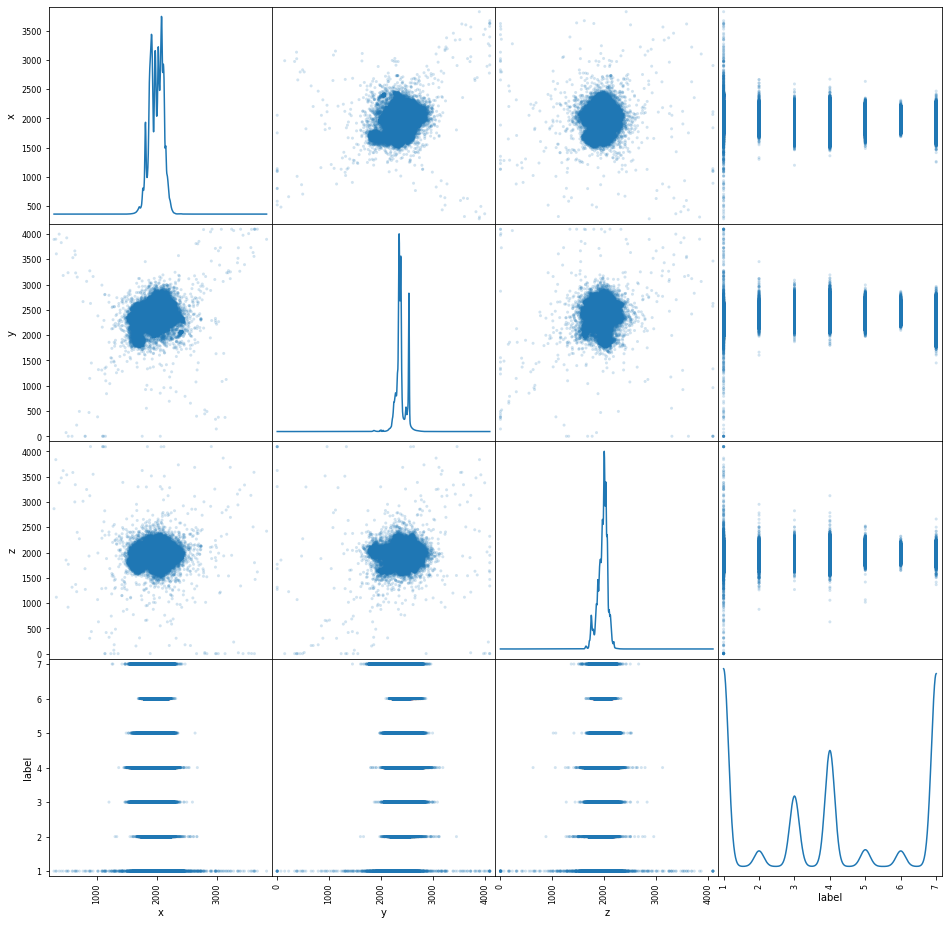

In [9]:
# Generate a scatter matrix to get a quick overview
scatter_matrix(ad, alpha=.2, figsize=(16,16), diagonal='kde')
# plt.savefig('scattermatrix.png')


Exploring feature:  x
x min: 282, max: 3828
(278.45300000000003, 459.3]    0.000003
(459.3, 636.6]                 0.000004
(636.6, 813.9]                 0.000004
(813.9, 991.2]                 0.000004
(991.2, 1168.5]                0.000009
(1168.5, 1345.8]               0.000016
(1345.8, 1523.1]               0.000063
(1523.1, 1700.4]               0.005814
(1700.4, 1877.7]               0.156155
(1877.7, 2055.0]               0.513669
(2055.0, 2232.3]               0.319199
(2232.3, 2409.6]               0.004890
(2409.6, 2586.9]               0.000112
(2586.9, 2764.2]               0.000028
(2764.2, 2941.5]               0.000008
(2941.5, 3118.8]               0.000009
(3118.8, 3296.1]               0.000005
(3296.1, 3473.4]               0.000004
(3473.4, 3650.7]               0.000004
(3650.7, 3828.0]               0.000001
Name: x, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


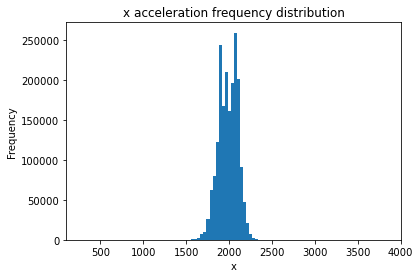

Exploring feature:  y
y min: 2, max: 4095
(-2.094, 206.65]     0.000006
(206.65, 411.3]      0.000003
(411.3, 615.95]      0.000003
(615.95, 820.6]      0.000002
(820.6, 1025.25]     0.000004
(1025.25, 1229.9]    0.000004
(1229.9, 1434.55]    0.000010
(1434.55, 1639.2]    0.000014
(1639.2, 1843.85]    0.000410
(1843.85, 2048.5]    0.005820
(2048.5, 2253.15]    0.057007
(2253.15, 2457.8]    0.717861
(2457.8, 2662.45]    0.214139
(2662.45, 2867.1]    0.004597
(2867.1, 3071.75]    0.000083
(3071.75, 3276.4]    0.000017
(3276.4, 3481.05]    0.000003
(3481.05, 3685.7]    0.000005
(3685.7, 3890.35]    0.000004
(3890.35, 4095.0]    0.000010
Name: y, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


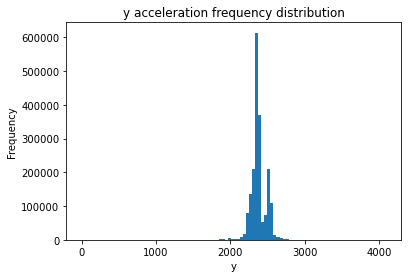

Exploring feature:  z
z min: 1, max: 4095
(-3.0949999999999998, 205.7]    0.000013
(205.7, 410.4]                  0.000003
(410.4, 615.1]                  0.000003
(615.1, 819.8]                  0.000005
(819.8, 1024.5]                 0.000007
(1024.5, 1229.2]                0.000014
(1229.2, 1433.9]                0.000033
(1433.9, 1638.6]                0.001169
(1638.6, 1843.3]                0.096344
(1843.3, 2048.0]                0.725630
(2048.0, 2252.7]                0.176110
(2252.7, 2457.4]                0.000601
(2457.4, 2662.1]                0.000031
(2662.1, 2866.8]                0.000012
(2866.8, 3071.5]                0.000005
(3071.5, 3276.2]                0.000005
(3276.2, 3480.9]                0.000005
(3480.9, 3685.6]                0.000005
(3685.6, 3890.3]                0.000002
(3890.3, 4095.0]                0.000005
Name: z, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


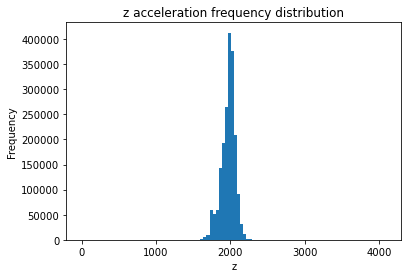

In [36]:
# Explore acceleration data point distribution
def explore_acc(feature='x'):
    print('Exploring feature: ', feature)
    feat = ad[feature]
    print(f"{feature} min: {ad[feature].min()}, max: {ad[feature].max()}")
    # show frequency distribution
    print(feat.value_counts(bins=20, normalize=True, sort=False))
    # plot distribution
    print(feat.plot.hist(bins=100))
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    plt.title(f"{feature} acceleration frequency distribution")
    
    plt.savefig(f"{feature}-histogram")
    plt.show()

for acc in accs:
    explore_acc(acc)

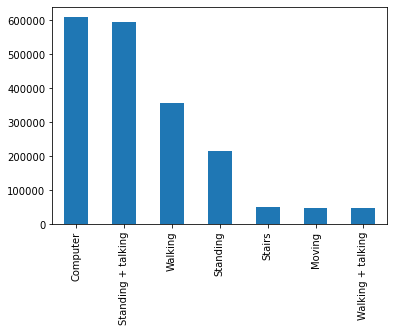

In [35]:
# Explore class types and distribution 
ad['label_readable'].value_counts().plot.bar()
plt.ylabel('Frequency')
plt.savefig('class-bar-chart')

<ipython-input-11-0ac10fc27de6>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-11-0ac10fc27de6>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-11-0ac10fc27de6>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


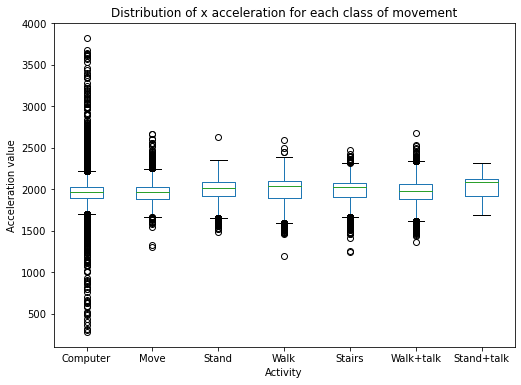

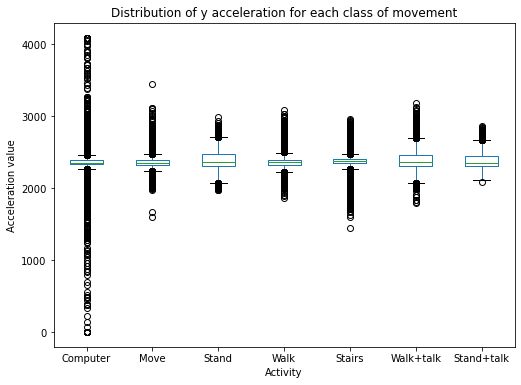

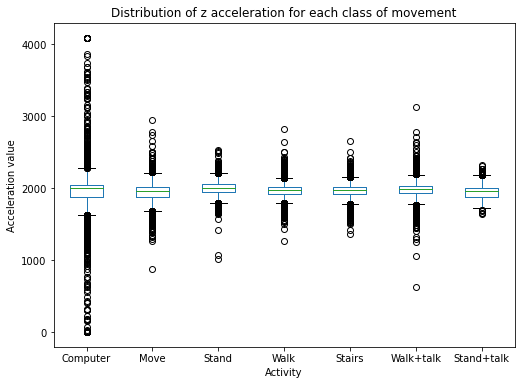

In [11]:
# Explore pair of attributes (columns)
# plot class against each acceleration
for acc in accs:
    fig, ax = plt.subplots(figsize=(8,6))
    ad.boxplot(column=acc, by='label_readable', ax=ax, grid=False)
    ax.set_xticklabels(labels_short)
    plt.xlabel('Activity')
    plt.ylabel('Acceleration value')
    plt.title(f"Distribution of {acc} acceleration for each class of movement")
    plt.suptitle('')
    plt.savefig(f"{acc}-class-boxplot")
    fig.show()
    #break


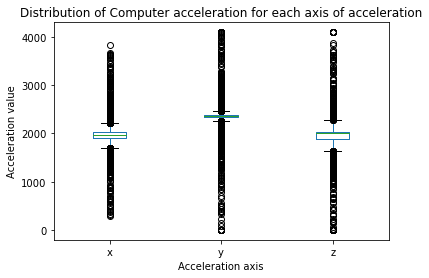

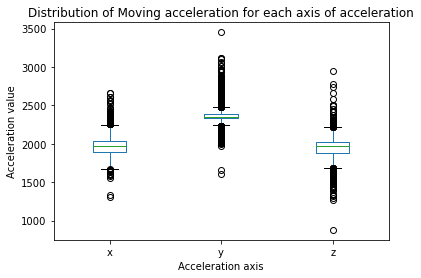

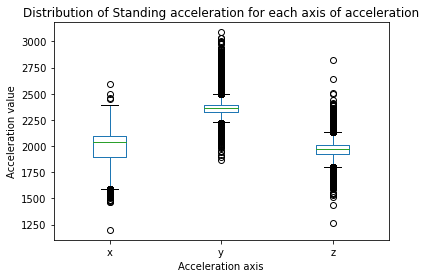

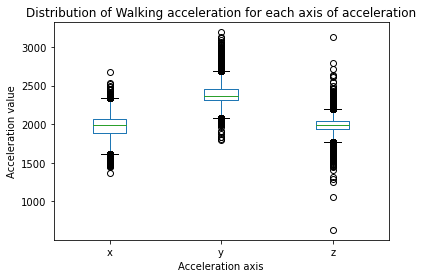

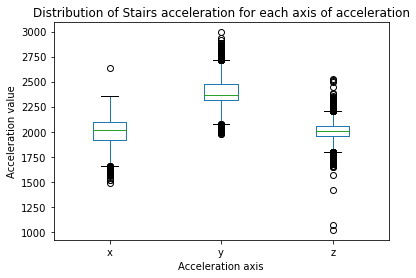

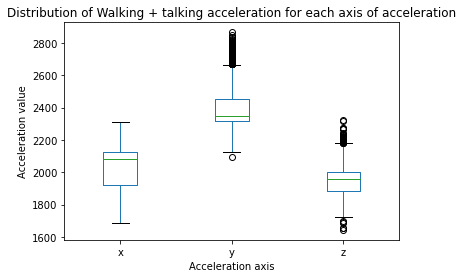

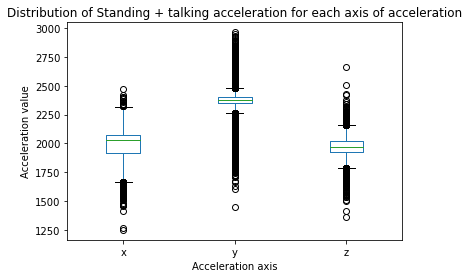

In [12]:
# Shows distribution of accelerations for each activity.
for label in labels:
    label_acc = ad.loc[ad['label_readable'] == label, accs]
    fig, ax = plt.subplots()
    label_acc.boxplot(grid=False)
    plt.xlabel('Acceleration axis')
    plt.ylabel('Acceleration value')
    plt.title(f"Distribution of {label} acceleration for each axis of acceleration")
    plt.suptitle('')
    plt.show()

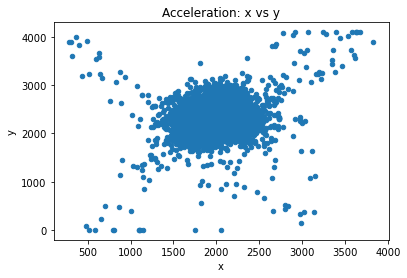

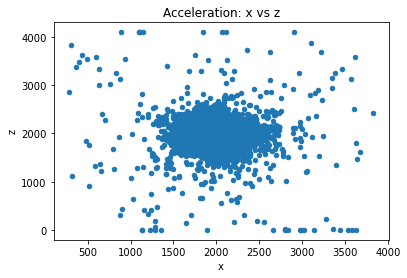

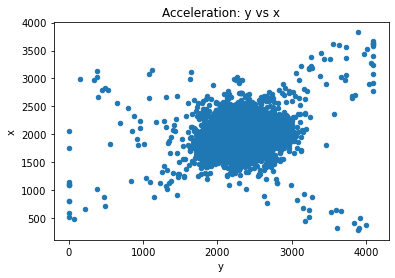

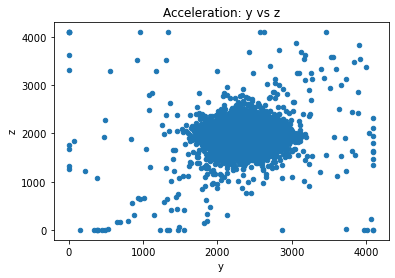

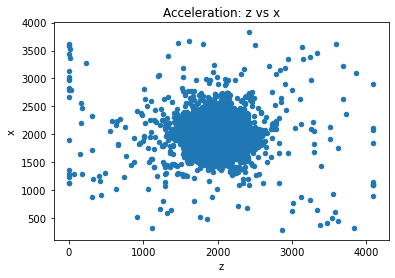

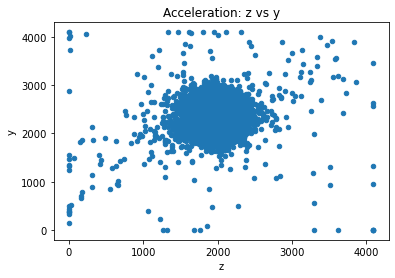

In [13]:
# Hypothesis: I expect to see some relationship between accelerations, eg.
# walking in stairs would have both x acc and y acc higher, but walking flat would
# have little change in y, but maybe more in z.
# Result: I can see some groupings/clusters forming, but I cannot see which
# classes are forming these clusters. Need to color code
for acc in accs:
    for acc2 in accs:
        if acc == acc2: continue
        ad.plot.scatter(x=acc, y=acc2)
        plt.title(f"Acceleration: {acc} vs {acc2}")
        plt.xlabel(f"{acc}")
        plt.ylabel(f"{acc2}")
        plt.show()

x y


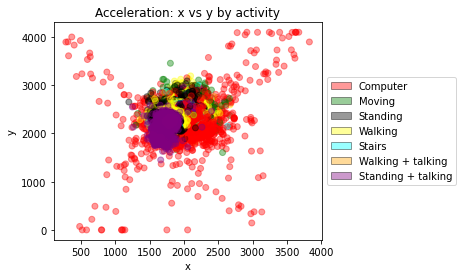

x z


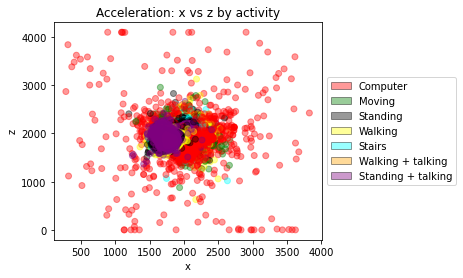

y z


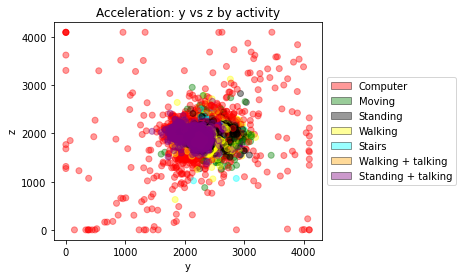

In [38]:
# TASK: Explore the relationship between all pairs of attributes
# Compare class label, vs accelerations
# Hypothesis: This will show me how they are clustered, the task which I want to do
# Result:

acc_pairs = [('x', 'y'), ('x', 'z'), ('y', 'z')]
for acc1, acc2 in acc_pairs:
    print(acc1, acc2)
    fig, ax = plt.subplots()
    ax.scatter(x=ad[acc1], y=ad[acc2], c=ad['color'], alpha=0.4)
    plt.title(f"Acceleration: {acc1} vs {acc2} by activity")
    plt.xlabel(f"{acc1}")
    plt.ylabel(f"{acc2}")
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    #retrieve values from color dictionary and attribute it to corresponding labels
    leg_el = [mpatches.Patch(facecolor = value, edgecolor = "black", label = key, alpha = 0.4) for key, value in label_color.items()]
    
    # Put a legend to the right of the current axis
    ax.legend(handles = leg_el, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(f"{acc1}-{acc2}-class-colour-scatter-(all: {LOAD_SINGLE_DATASET})")
    plt.show()

    



          x     y     z
0      1502  2215  2153
1      1667  2072  2047
2      1611  1957  1906
3      1601  1939  1831
4      1643  1965  1879
...     ...   ...   ...
33672  1913  2391  2059
33673  1916  2399  2045
33674  1905  2388  2045
33675  1891  2385  2049
33676  1890  2375  2052

[33677 rows x 3 columns]
0        1502
1        1667
2        1611
3        1601
4        1643
         ... 
33672    1913
33673    1916
33674    1905
33675    1891
33676    1890
Name: x, Length: 33677, dtype: int64
0        2215
1        2072
2        1957
3        1939
4        1965
         ... 
33672    2391
33673    2399
33674    2388
33675    2385
33676    2375
Name: y, Length: 33677, dtype: int64
0        2153
1        2047
2        1906
3        1831
4        1879
         ... 
33672    2059
33673    2045
33674    2045
33675    2049
33676    2052
Name: z, Length: 33677, dtype: int64


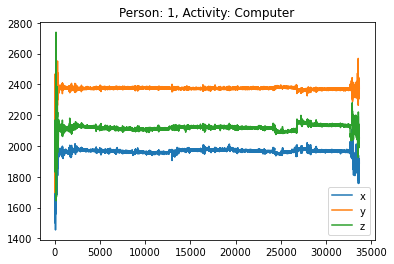

          x     y     z
33677  1888  2374  2053
33678  1905  2375  2049
33679  1910  2381  2044
33680  1921  2377  2048
33681  1917  2386  2047
...     ...   ...   ...
34600  1914  2302  2071
34601  1927  2335  2040
34602  1939  2370  2014
34603  1947  2391  1995
34604  1954  2385  2007

[928 rows x 3 columns]
33677    1888
33678    1905
33679    1910
33680    1921
33681    1917
         ... 
34600    1914
34601    1927
34602    1939
34603    1947
34604    1954
Name: x, Length: 928, dtype: int64
33677    2374
33678    2375
33679    2381
33680    2377
33681    2386
         ... 
34600    2302
34601    2335
34602    2370
34603    2391
34604    2385
Name: y, Length: 928, dtype: int64
33677    2053
33678    2049
33679    2044
33680    2048
33681    2047
         ... 
34600    2071
34601    2040
34602    2014
34603    1995
34604    2007
Name: z, Length: 928, dtype: int64


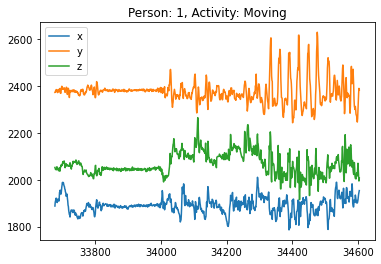

          x     y     z
34605  1953  2359  2016
34606  1944  2327  2015
34607  1954  2344  2025
34608  1941  2398  2093
34609  1904  2468  2133
...     ...   ...   ...
75830  1880  2376  1979
75831  1870  2379  1969
75832  1876  2377  1976
75833  1874  2385  1979
75834  1873  2378  1972

[11179 rows x 3 columns]
34605    1953
34606    1944
34607    1954
34608    1941
34609    1904
         ... 
75830    1880
75831    1870
75832    1876
75833    1874
75834    1873
Name: x, Length: 11179, dtype: int64
34605    2359
34606    2327
34607    2344
34608    2398
34609    2468
         ... 
75830    2376
75831    2379
75832    2377
75833    2385
75834    2378
Name: y, Length: 11179, dtype: int64
34605    2016
34606    2015
34607    2025
34608    2093
34609    2133
         ... 
75830    1979
75831    1969
75832    1976
75833    1979
75834    1972
Name: z, Length: 11179, dtype: int64


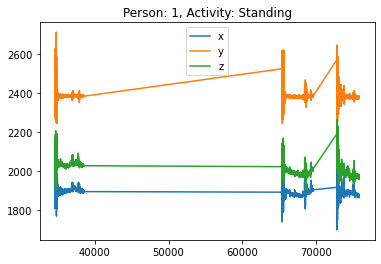

          x     y     z
38488  1895  2390  2024
38489  1889  2389  2022
38490  1886  2383  2027
38491  1888  2382  2028
38492  1889  2385  2027
...     ...   ...   ...
65343  1816  2460  2003
65344  1785  2469  2003
65345  1787  2465  1999
65346  1837  2593  2081
65347  1844  2567  2106

[26860 rows x 3 columns]
38488    1895
38489    1889
38490    1886
38491    1888
38492    1889
         ... 
65343    1816
65344    1785
65345    1787
65346    1837
65347    1844
Name: x, Length: 26860, dtype: int64
38488    2390
38489    2389
38490    2383
38491    2382
38492    2385
         ... 
65343    2460
65344    2469
65345    2465
65346    2593
65347    2567
Name: y, Length: 26860, dtype: int64
38488    2024
38489    2022
38490    2027
38491    2028
38492    2027
         ... 
65343    2003
65344    2003
65345    1999
65346    2081
65347    2106
Name: z, Length: 26860, dtype: int64


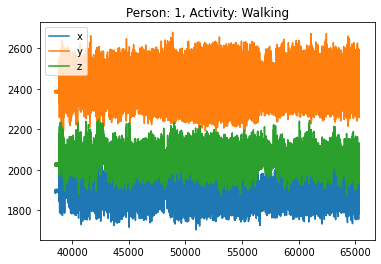

          x     y     z
69595  1904  2390  2010
69596  1908  2390  2009
69597  1907  2390  2005
69598  1899  2387  1999
69599  1906  2387  2008
...     ...   ...   ...
72781  1838  2427  2110
72782  1833  2450  2117
72783  1842  2484  2132
72784  1848  2536  2182
72785  1877  2579  2207

[3191 rows x 3 columns]
69595    1904
69596    1908
69597    1907
69598    1899
69599    1906
         ... 
72781    1838
72782    1833
72783    1842
72784    1848
72785    1877
Name: x, Length: 3191, dtype: int64
69595    2390
69596    2390
69597    2390
69598    2387
69599    2387
         ... 
72781    2427
72782    2450
72783    2484
72784    2536
72785    2579
Name: y, Length: 3191, dtype: int64
69595    2010
69596    2009
69597    2005
69598    1999
69599    2008
         ... 
72781    2110
72782    2117
72783    2132
72784    2182
72785    2207
Name: z, Length: 3191, dtype: int64


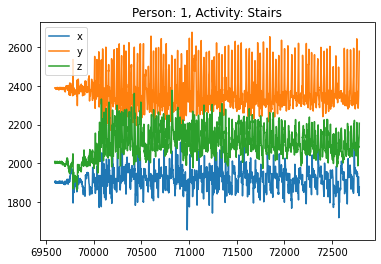

          x     y     z
75835  1878  2378  1973
75836  1871  2370  1973
75837  1877  2373  1977
75838  1870  2375  1972
75839  1873  2371  1979
...     ...   ...   ...
78747  1899  2396  2117
78748  1892  2398  2107
78749  1889  2389  2112
78750  1881  2384  2113
78751  1879  2365  2107

[2917 rows x 3 columns]
75835    1878
75836    1871
75837    1877
75838    1870
75839    1873
         ... 
78747    1899
78748    1892
78749    1889
78750    1881
78751    1879
Name: x, Length: 2917, dtype: int64
75835    2378
75836    2370
75837    2373
75838    2375
75839    2371
         ... 
78747    2396
78748    2398
78749    2389
78750    2384
78751    2365
Name: y, Length: 2917, dtype: int64
75835    1973
75836    1973
75837    1977
75838    1972
75839    1979
         ... 
78747    2117
78748    2107
78749    2112
78750    2113
78751    2107
Name: z, Length: 2917, dtype: int64


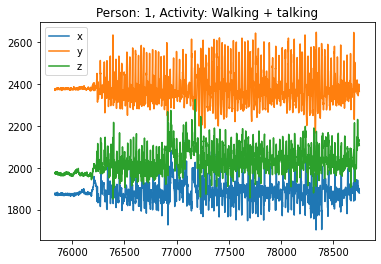

           x     y     z
78752   1879  2356  2106
78753   1893  2370  2123
78754   1907  2373  2132
78755   1890  2372  2102
78756   1878  2358  2069
...      ...   ...   ...
162495  1926  2382  2072
162496  1927  2388  2074
162497  1930  2383  2074
162498  1929  2385  2076
162499  1926  2385  2078

[83748 rows x 3 columns]
78752     1879
78753     1893
78754     1907
78755     1890
78756     1878
          ... 
162495    1926
162496    1927
162497    1930
162498    1929
162499    1926
Name: x, Length: 83748, dtype: int64
78752     2356
78753     2370
78754     2373
78755     2372
78756     2358
          ... 
162495    2382
162496    2388
162497    2383
162498    2385
162499    2385
Name: y, Length: 83748, dtype: int64
78752     2106
78753     2123
78754     2132
78755     2102
78756     2069
          ... 
162495    2072
162496    2074
162497    2074
162498    2076
162499    2078
Name: z, Length: 83748, dtype: int64


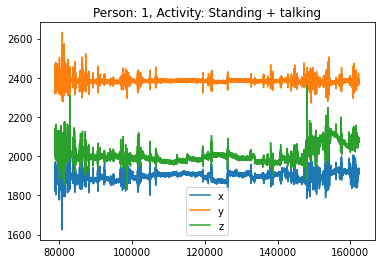

In [74]:
for p in range(1, 16):
    for activity in labels:
        fig, ax = plt.subplots()
        plt.title(f"Person: {p}, Activity: {activity}")
        d  = ad.loc[(ad['person'] == p) & (ad['label_readable'] == activity), accs]
        print(d)
        for acc in accs:
            ds = d[acc]
            print(ds)
            ds.plot(label=acc)
        plt.legend()
        plt.show()
    break

In [143]:
# takes dataframe with 1 person and 1 activity, windows it, and returns a new dataframe with new features
# wsize defaults to 1 second (=52 Hz)
# returns mean, std, max-min, 
def windowing(df, wsize=52):
    person = df['person'][0]
    df_list = []  # storing dicts in a list then creating dataframe in the end is much faster
    slide = 0  # slide will slide over the time series, increasing wsize//2 each iteration
    window = wsize
    size = len(df.index)
    for label in label_i:
        df_t = df.loc[df['label'] == label, :]
        label_readable, color = df_t['label_readable'][0], 
        while slide < size:
            rows = df.iloc[slide:window][accs]
            df_list.append({
                'person': person,
                'label': label,
                'label_readable': label_readable,
                'x mean': rows['x'].mean(), 
                'y mean': rows['y'].mean(), 
                'z mean': rows['z'].mean(),
                'x std': rows['x'].std(),
                'y std': rows['y'].std(),
                'z std': rows['z'].std(),
                'x diff': rows['x'].max() - rows['x'].min(),
                'y diff': rows['y'].max() - rows['y'].min(),
                'z diff': rows['z'].max() - rows['z'].min(),
                'color': color
                })

            window = slide + wsize
            slide += wsize//2

    return pd.DataFrame(df_list)
        
#windowing(ad.loc[(ad['person'] == 1) & (ad['label'] == 1)].reset_index())

ad = DataFrame()
# find all csv files
if LOAD_WHOLE_DATASET:
    files = glob.glob('data/*.csv')
else:
    files = ['data/2.csv']

# concatenate all 15 data files
# usecols is used to skip reading the 'id' column, which has errors
for file in files:
    person_data = pd.read_csv(file, sep=',', header=None, names=columns,
                 usecols=[1,2,3,4])
    # Add a column person, which specifies which dataset a row is from
    person_id = file.split('data/')[1].split('.csv')[0]
    person_data['person'] = int(person_id)
    df_windowd = windowing()
    ad = pd.concat([ad, person_data])

,person,label,label_readable,x mean,y mean,z mean,x std,y std,z std,x diff,y diff,z diff,color
0,1,1,Computer,1598.923077,2001.673077,2004.000000,39.374943,115.800491,71.632504,192,771,322,red
1,1,1,Computer,1609.615385,1964.192308,2046.307692,28.684598,61.166016,46.296237,133,349,206,red
2,1,1,Computer,1585.461538,2022.846154,2086.615385,50.308831,42.165097,52.471003,199,152,179,red
3,1,1,Computer,1668.730769,2175.153846,2045.769231,43.481083,86.539097,95.318963,171,345,412,red
4,1,1,Computer,1738.076923,2240.769231,1914.153846,115.771473,93.420044,200.639915,391,498,1068,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,1,1,Computer,1825.884615,2338.692308,2123.538462,41.517540,27.474744,54.530161,182,117,234,red
1292,1,1,Computer,1838.307692,2371.192308,2055.346154,39.042304,38.494695,36.850989,154,131,139,red
1293,1,1,Computer,1847.192308,2364.461538,2087.500000,29.295760,36.818724,31.612972,87,130,115,red
1294,1,1,Computer,1866.923077,2376.807692,2082.500000,26.252502,19.030542,19.469463,97,77,84,red


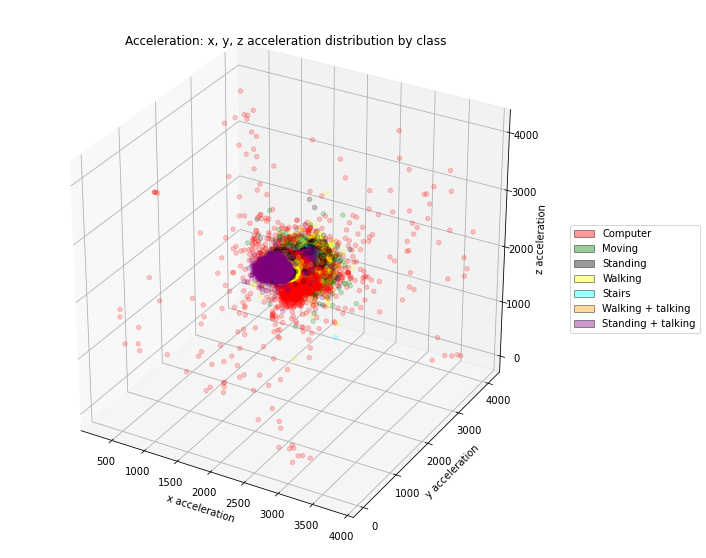

In [15]:
# 3D plot
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(ad['x'], ad['y'], ad['z'], c=ad['color'], alpha=.2)
plt.title(f"Acceleration: x, y, z by class")
ax.set_xlabel(f"x acceleration")
ax.set_ylabel(f"y acceleration")
ax.set_zlabel('z acceleration')
leg_el = [mpatches.Patch(facecolor = value, edgecolor = "black", label = key, alpha = 0.4) for key, value in label_color.items()]
# Put a legend to the right of the current axis
ax.legend(handles = leg_el, loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(f"3d-scatter")
plt.show()


In [16]:
# PART 3: MODELING
# The goal of the modeling is to see if it is possible to classify an unknown
# activity (one or a set of data points). This is classification, so possible
# models are knn, decision tree.

In [17]:
X = ad.loc[:, ['x', 'y', 'z']]
y = ad.loc[:, 'label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [18]:
# KNN
neighbours = 3
clf = KNeighborsClassifier(n_neighbors=neighbours)
fit = clf.fit(X_train, y_train)
y_pred = fit.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[137605,   2215,   2183,   4289,    221,     90,   5949],
       [  4804,   2772,    877,   1994,     66,     41,   1483],
       [  4705,   1167,  25973,  10033,   1331,    729,  10281],
       [  9419,   2443,  11612,  54866,   1112,    454,   9054],
       [  1582,    296,   3268,   4051,   1602,    274,   1881],
       [   813,    188,   2187,   2132,    404,   2279,   3813],
       [  9827,   1905,  11730,   9876,    774,   1780, 112365]])

In [19]:
# Decision tree

clf = DecisionTreeClassifier(
    max_depth=4,
    min_samples_split=10

)
fit = clf.fit(X_train, y_train)
y_pred = fit.predict(X_test)
confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))


/usr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.76      0.83      0.80    152552
           2       0.56      0.04      0.07     12037
           3       0.42      0.20      0.27     54219
           4       0.59      0.60      0.60     88960
           5       0.00      0.00      0.00     12954
           6       0.00      0.00      0.00     11816
           7       0.61      0.81      0.69    148257

    accuracy                           0.65    480795
   macro avg       0.42      0.35      0.35    480795
weighted avg       0.60      0.65      0.61    480795



In [20]:
# Save tree
from sklearn import tree


with open('activity.dot', 'w') as f:
    f = tree.export_graphviz(clf, out_file=f, feature_names=['x', 'y', 'z'], class_names=labels,
                             filled=True, rounded=True, special_characters=True)